In [682]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import tensorflow.keras.backend as be

In [674]:
df = pd.read_csv("boston_corrected.csv")
train_set, test_set = train_test_split(df, test_size=0.1, random_state=26)


For our project, we wanted to create an app that allows a user to find approximate values for a given set of variables, based on a coordinate in and around Boston. To do this, we needed to be able to predict all of our desired values based only on the longitude and latitude values.

We found the best way to do this was to use a nested set of models. We use our first model to predict our first desired variable using just our longitude and latitude. We then use our second model to find our second desired variable using longitude, latitude, and the variable we just calculated. In this way, we end up with a more accurate set of calculated variables.

The order of these variables was important. We found that some varaibles, such as "DIS" could be found to a high degree of accuracy ($\approx 5.5% $ error) using only positional data, whereas other variables, such as "CMEDV" needed far more input variables to return an accurate number.

Sadly, our final house price prediction was only accurate within around 8%-10%. Part of this is due to the fact that one of the most important varaibles for finding CMEDV was LSTAT. However, we had great difficultly predicting LSTAT, only ever getting it with $20\%$ error, as a result, we discard it.

In [740]:
input_vars = ["LON", "LAT"] #Input variables
#output vars in order of which we wish to calculate
output_vars = ['DIS', "RM", "TOWNNO","NOX",'PTRATIO', 'TAX', "INDUS","RAD", "AGE", "LSTAT", 'CMEDV']
#batch size for each varaible, matched by index
all_batchsize = [150, 200, 200, 200, 200, 200, 200, 200, 200,400, 300]

#Each model has different number of input variables, so we need a new scaler for each
INPUT_SCALER = StandardScaler()
INPUT_SCALER.fit(df[input_vars].values)

input_scalers = {"LAT": INPUT_SCALER}
current_vars =["LON", "LAT"] 
for output in output_vars:
    current_vars.append(output)
    INPUT_SCALER_n = StandardScaler()
    INPUT_SCALER_n.fit(df[current_vars].values)
    

    input_scalers[output] = INPUT_SCALER_n
    print("Input scaler: ", len(input_scalers), " is ", current_vars, " with key: ",output )


INPUT = INPUT_SCALER.transform(train_set[input_vars])
INPUT_TEST = INPUT_SCALER.transform(test_set[input_vars])

Input scaler:  2  is  ['LON', 'LAT', 'DIS']  with key:  DIS
Input scaler:  3  is  ['LON', 'LAT', 'DIS', 'RM']  with key:  RM
Input scaler:  4  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO']  with key:  TOWNNO
Input scaler:  5  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX']  with key:  NOX
Input scaler:  6  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO']  with key:  PTRATIO
Input scaler:  7  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX']  with key:  TAX
Input scaler:  8  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS']  with key:  INDUS
Input scaler:  9  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS', 'RAD']  with key:  RAD
Input scaler:  10  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS', 'RAD', 'AGE']  with key:  AGE
Input scaler:  11  is  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS', 'RAD', 'AGE', 'LSTAT']  with key:  LSTAT
Input scaler:  12  is  [

In [747]:

def CreateModel(inSize):
    """
    Creates a simple Sequential model with the desired input size
    
    Parameters
    ----------
    inSize : int
        Input size for md
        
    Returns
    ------
        Sequential Model (Compiled)
    """
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(inSize))

    model.add(keras.layers.Dense(40, activation='relu'))
    model.add(keras.layers.Dense(40, activation='sigmoid'))
    model.add(keras.layers.Dense(40, activation='relu'))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss="mse", optimizer="adam", metrics=["mean_squared_error"])

    return model

def TrainModel(model, input_vars, output_var, epochs, batch_size):
    """
    Trains our model based on the supplied parameters
    
    Parameters
    ----------
    model : Model
        Model we wish to train
    input_vars : string array
        Model input variable names
    output_var : string
        Model output variable name
    epochs : int
        Training epochs
    batch_size : int
        Training batch size
    
    returns
    --------
    Model Predict : float array
        Models prediction for the input variable names of the testing data set
    """
    #Get the variable so we can get our scaler
    most_recent = input_vars[len(input_vars)-1]
    input_scaler = input_scalers[most_recent]
    
    #Define our model target output
    OUTPUT = train_set[output_var].values
    
    #Define the input
    ThisInput = input_scaler.transform(train_set[input_vars].values)
    #train the model
    model.fit(ThisInput, OUTPUT, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #test the model with predictions
    InputTest = input_scaler.transform(test_set[input_vars])
    model_predict = model.predict(InputTest)
        
    return model_predict

In [755]:
def TrainAndTest(input_vars, output_var, debug=True, figFile=None):
    """
    Creates and train our model
    
    Parameters
    ---------
    input_vars : string array
        Model input variable names
    output_var : string
        Model output variable name
    debug : bool
        If true, we plot our true values, our models predicted values, and their difference
            to give an idea of model accuracy. We also print the % uncertainty of the model
            (default is true)
    figFile : str
        File path to save figure to. If none, no figure is saved
        
    Returns
    -------
    Model : our trained model
    """
    model = CreateModel(len(input_vars))
    batch = all_batchsize[output_vars.index(output_var)]
    
    predict_vals = TrainModel(model,input_vars, output_var, batch, 10)[:,0]
    
    if(debug):
    
        plt.title("Model prediction vs true value for variable " + output_var)
        plt.plot(predict_vals, label="Model Prediction")
        plt.plot(test_set[output_var].values, label="True Value")

        diff = abs(predict_vals - test_set[output_var].values).T


        plt.plot(diff, label="$|abs(y_true-y_pred)|$")

        plt.legend()
        delta = np.sum(diff)/np.sum(test_set[output_var].values)
        print("Uncertainty was ", (delta*100), "% for variable ", output_var)
        
        if(figFile != None):
            plt.savefig(figFile)

        plt.show()
    return model
    

Uncertainty was  6.409241321561986 % for variable  DIS


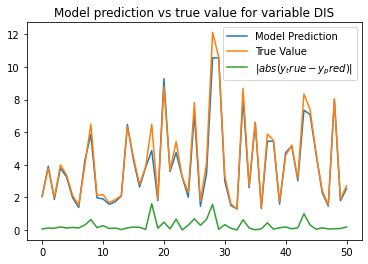

Model  0  has  2 vars:  ['LON', 'LAT']
Uncertainty was  6.8323590443892535 % for variable  RM


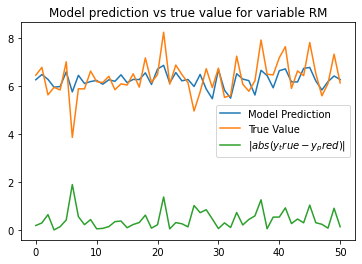

Model  1  has  3 vars:  ['LON', 'LAT', 'DIS']
Uncertainty was  8.13426404332174 % for variable  TOWNNO


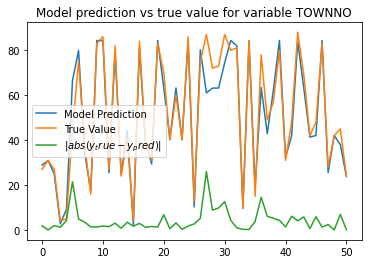

Model  2  has  4 vars:  ['LON', 'LAT', 'DIS', 'RM']
Uncertainty was  4.21743750120577 % for variable  NOX


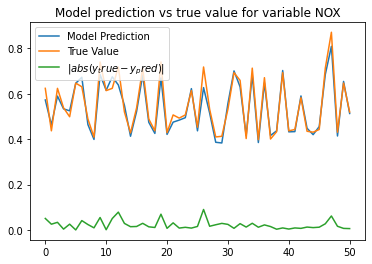

Model  3  has  5 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO']
Uncertainty was  4.678637460932362 % for variable  PTRATIO


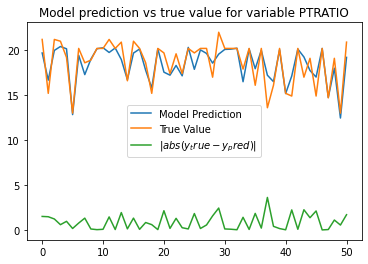

Model  4  has  6 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX']
Uncertainty was  4.917339812803374 % for variable  TAX


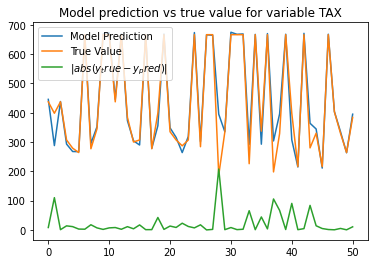

Model  5  has  7 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO']
Uncertainty was  4.65883705967292 % for variable  INDUS


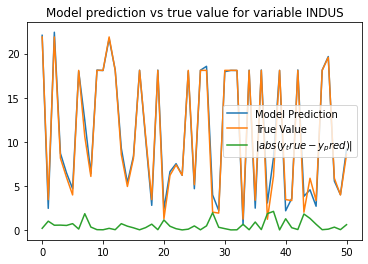

Model  6  has  8 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX']
Uncertainty was  3.3301493810570757 % for variable  RAD


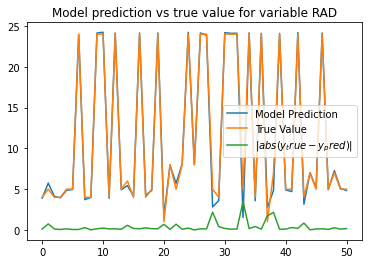

Model  7  has  9 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS']
Uncertainty was  13.905682626739333 % for variable  AGE


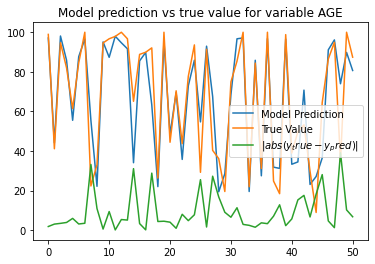

Model  8  has  10 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS', 'RAD']
Uncertainty was  21.738392020361285 % for variable  LSTAT


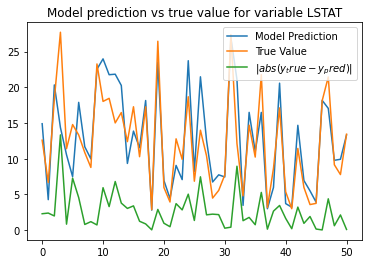

Model  9  has  11 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS', 'RAD', 'AGE']
Uncertainty was  9.09803063350967 % for variable  CMEDV


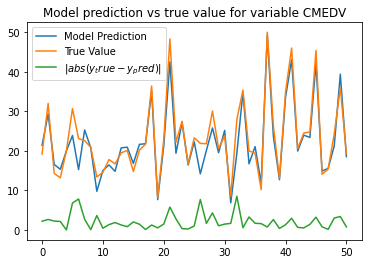

Model  10  has  12 vars:  ['LON', 'LAT', 'DIS', 'RM', 'TOWNNO', 'NOX', 'PTRATIO', 'TAX', 'INDUS', 'RAD', 'AGE', 'LSTAT']


In [759]:
#We iterate all of our output variables to create the relevent models to be used later
this_input_vars =  ["LON", "LAT"]

all_models = []


for i, var in enumerate(output_vars):
    all_models.append(TrainAndTest(this_input_vars, var, True, "figs/model_plot_" + var + ".png"))
    
    print("Model ", i , " has ", len(this_input_vars), "vars: ", this_input_vars)
    
    this_input_vars.append(var)

Now we have created our models, we can use them to predict values in and around Boston.
In this early stage, we also include an image of the Boston area. We can then display the relative values for any given variable on top of this map, to give an idea of the average value of a variable within an area.

In [684]:
map = mpimg.imread('map.png')
minLon = min(df["LON"].values)
maxLon = max(df["LON"].values)
minLat = min(df["LAT"].values)
maxLat = max(df["LAT"].values)


def latLonToXY(lat, lon):
    """
    Converts latitude and longitude to x-y positions on our map
    """
    lonScale = 2300
    dLon = 250
    latScale = 3200
    dLat = 280
    
    return (lon-minLon) * lonScale + dLon, map.shape[1] - ((lat-minLat) * latScale + dLat)


def XYToLat(x,y):
    """
    Converts x-y positions to longitude-latitude positions
    """
    lonScale = 2300
    dLon = 250
    latScale = 3200
    dLat = 280
    
    lon = (x - dLon)/lonScale + minLon
    lat = (map.shape[1]-y - dLat)/latScale + minLat
    return lon, lat

def CreateModelMask(model, scaler, gridSize=100, other_masks=None, maskCut=0):
    """
    Calculates the value of variable using the respective model, as well as values calculated by previous models.
    
    Parameters
    ---------
    model : Model
        Trained model
    scaler : StandardScaler
        The scaler we use to scale our input variables
    gridSize : int
        Width in pixels of each point on our map we wish to calculate values for
    other_masks : array(width,height, n)
        Masks that have previously been calculated
    maskCut: int
        Number of elements from 'other_masks' our model needs as an input
    
    Returns
    --------
    2d array representing the currently calculated value in a grid form over the boston area
    """
    height = int(map.shape[0] / gridSize)
    width = int(map.shape[1] / gridSize)
   # result = np.zeros((height, width, 4))

    extra_vars_len = maskCut

    result = np.zeros((height, width))
    LONLAT = np.zeros((height*width, 2+extra_vars_len))
    
    
    j = 0
    for x in range(width):
        for y in range(height):
            
            vals = np.zeros(2 + extra_vars_len)
            lon,lat = XYToLat(x*gridSize,y*gridSize)
            vals[0] = lon
            vals[1] = lat
            
            for i in range(extra_vars_len):
                vals[i+2] = other_masks[y,x, i]
            
            LONLAT[j,:] =  vals
            j+=1
    
    scaled = scaler.transform(LONLAT)
    predict =  model.predict(scaled)

    i=0
    for x in range(width):
        for y in range(height):
            result[y,x] = predict[i]
            i+=1

            
    return result
    


In [749]:

def CreateAllMasks(models, gridSize=20):
    """
    Creates the value masks for all desired output variables
    """
    
    height = int(map.shape[0] / gridSize)
    width = int(map.shape[1] / gridSize)
    #create array to hld result
    each_mask = np.zeros((height, width, len(output_vars)))
    
    this_output = ["LAT"] + output_vars
    
    
    #We iterate each variable, our model 'i' will predict
    for i,var in enumerate(this_output):
        if(i == len(this_output)-1):
            break

        #we get the model that tries to find the current var
        model = models[i]
        #get the current scaler
        scaler = input_scalers[var]
        #create this mask
        cur_mask = CreateModelMask(models[i], scaler, gridSize, each_mask, i)
        each_mask[:,:,i] = cur_mask
        
        
   

    # a large part of our map is simply the ocean, and so we wish to ensure there
    #are no variable values here.
    #We perform a colour analysis on the map pixels to decide if we can calculate a variabel value here
    MASK = np.ones((height, width)) * 0.5

    for x in range(width):
        for y in range(height):
            map_col = map[y*gridSize,x * gridSize]

            if(map_col[0]< 175.0/255 and map_col[1] < 220.0/255 and map_col[2] > 210/255.0):
                MASK[y,x] = 0
    #We mutliple our variable masks by our Map mask to remove useless values
    for i in range(len(output_vars)):
        each_mask[:,:,i] =each_mask[:,:,i] * MASK
        
    return each_mask, MASK
end_mask, MASK = CreateAllMasks(all_models, 5)


We now have generated all our value maps. We can display this along side representations of the true data, to get an idea of the overall accuracy of our models.

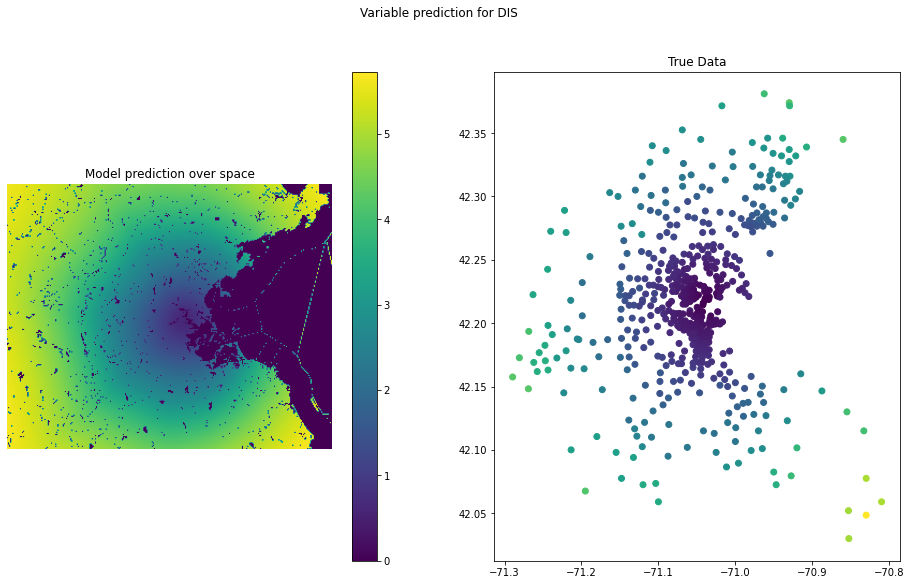

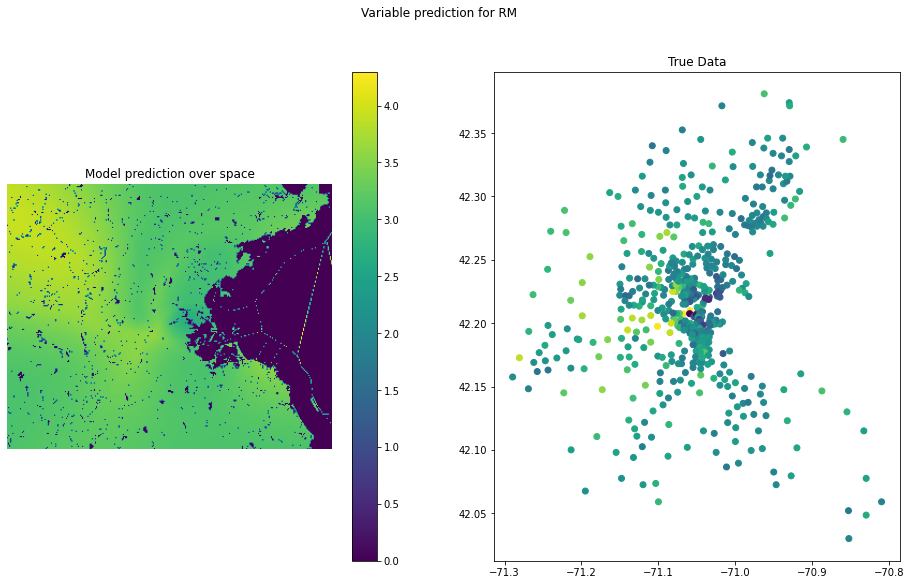

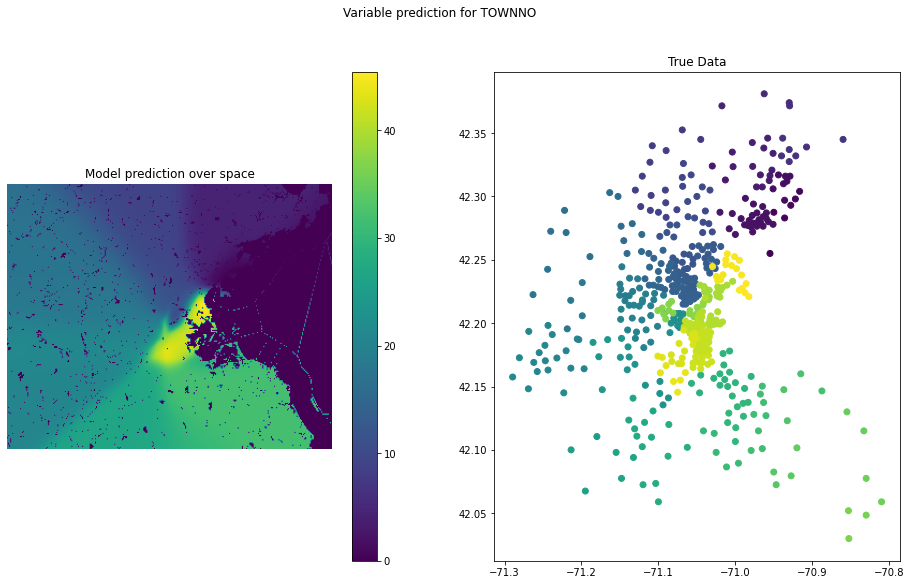

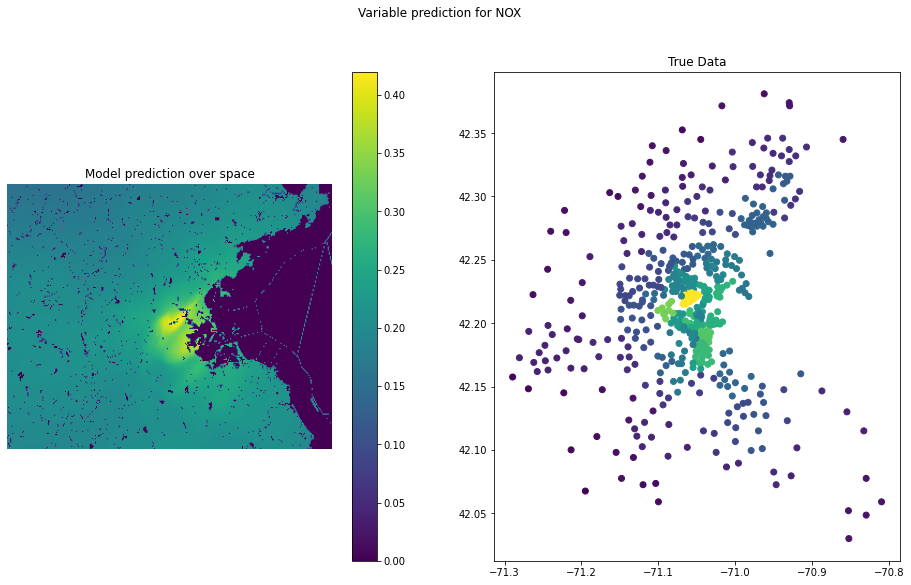

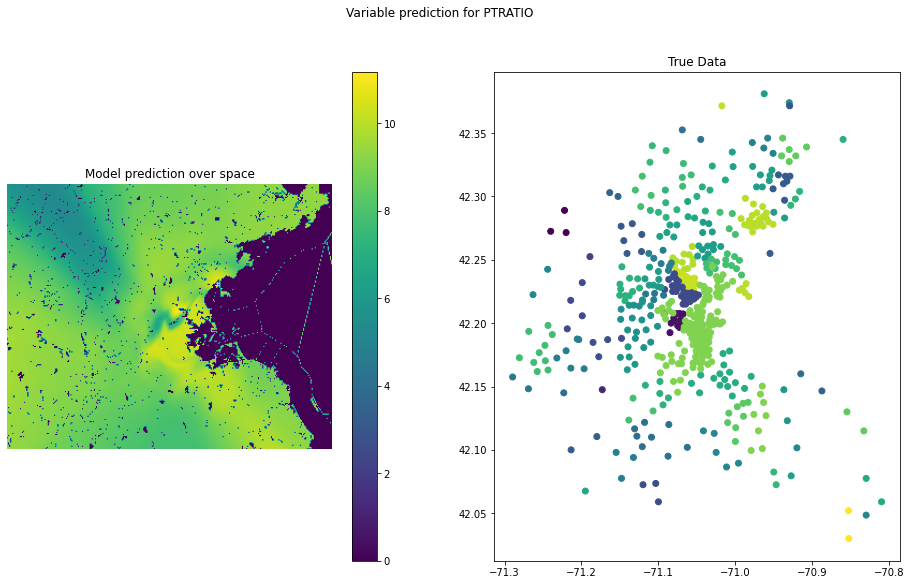

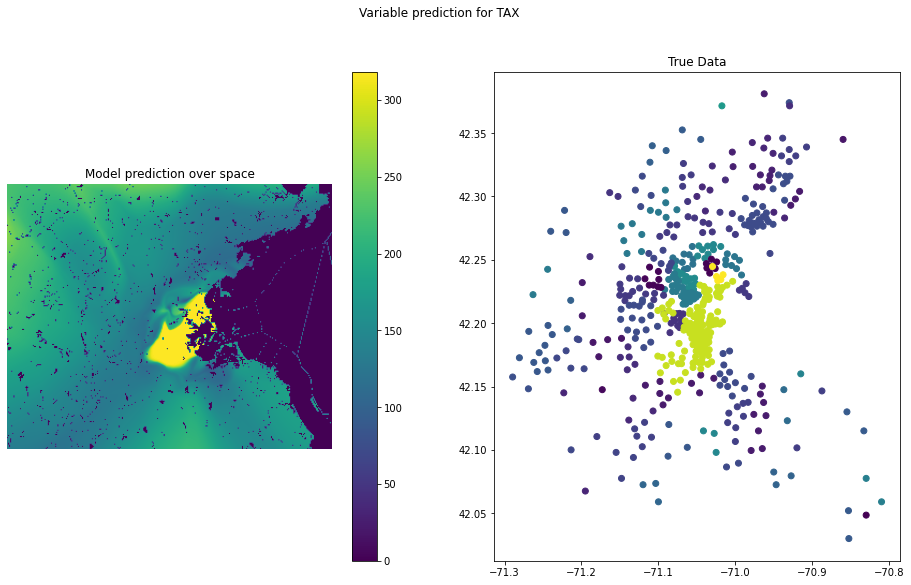

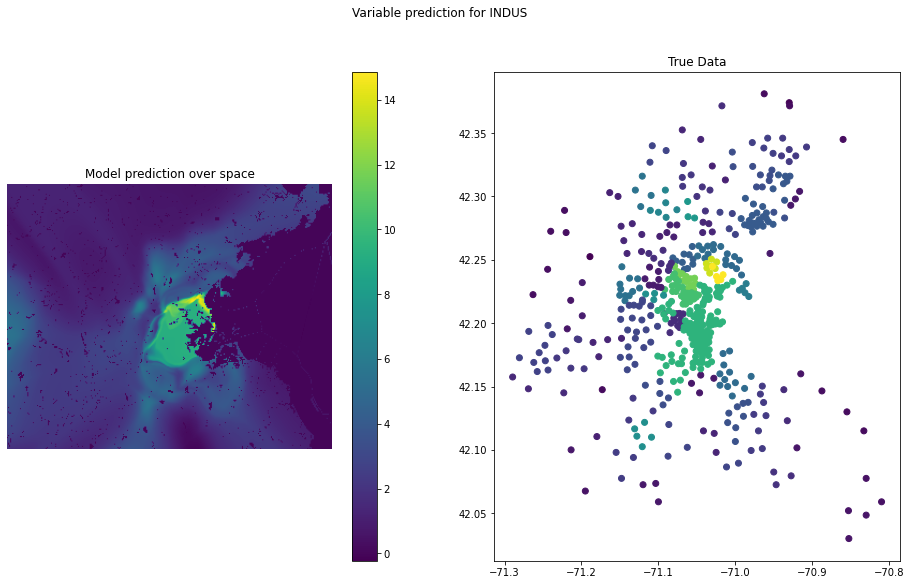

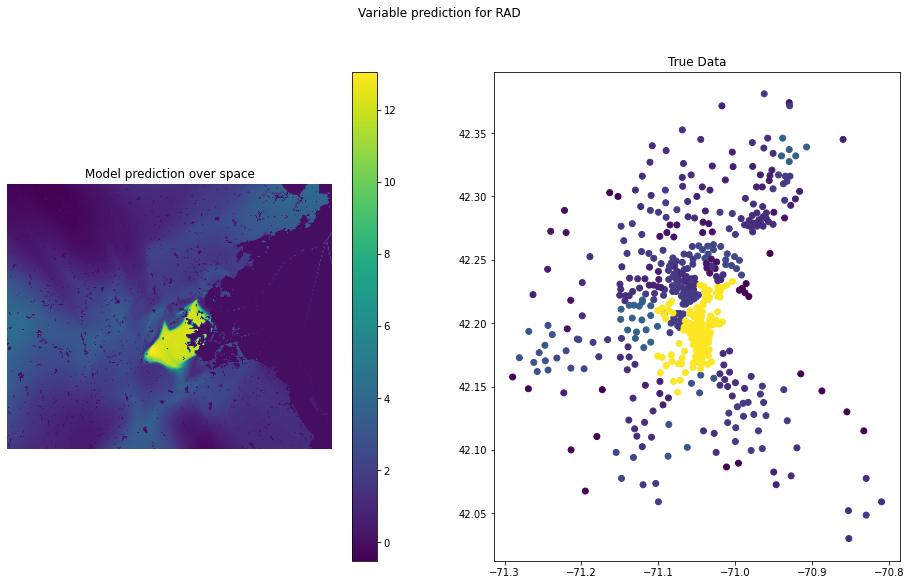

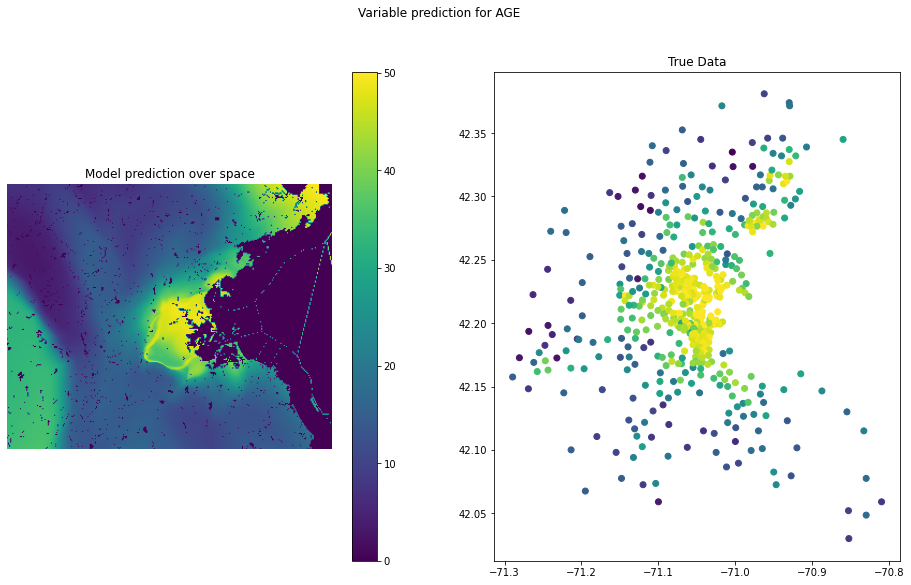

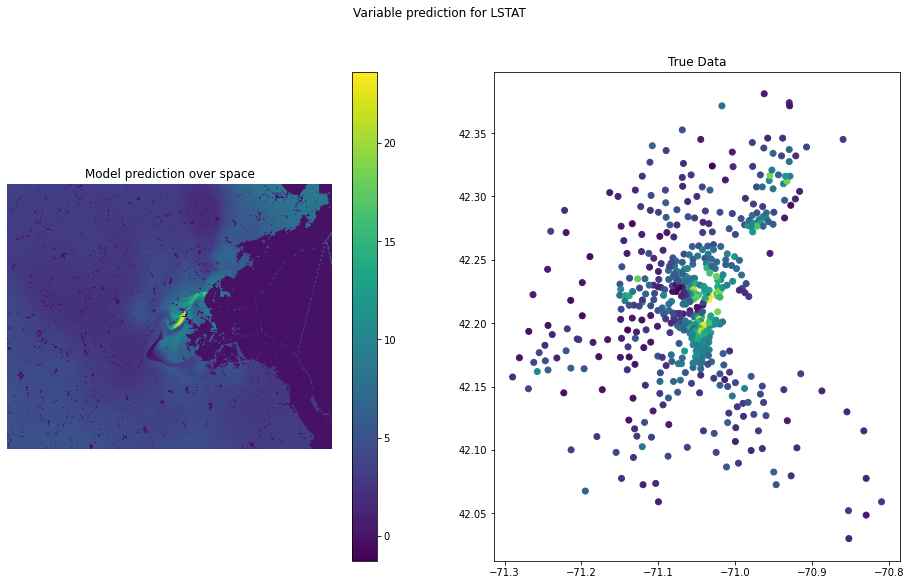

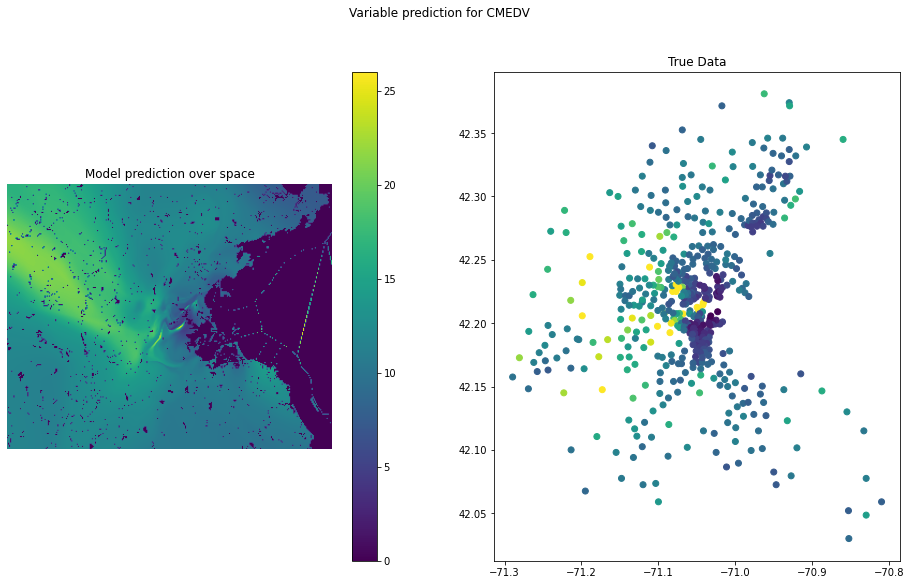

In [760]:

N = len(output_vars)
subX = int(np.sqrt(N))

#fig = plt.figure(figsize=(12,9))

for i in range(N):
    #ax = fig.add_subplots(N,N,i+1)
    fig = plt.figure(figsize=(16,9))
    ax1 = fig.add_subplot(1,2,1)
    ax1.axis('off')

    ax1.set_title("Model prediction over space")
    im = ax1.imshow(end_mask[:,:,i])
    fig.colorbar(im)
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(df["LON"].values, df["LAT"].values, c=df[output_vars[i]].values)
    ax2.set_title("True Data")
    
    fig.suptitle("Variable prediction for " + output_vars[i])
    plt.savefig("figs/" + output_vars[i] + ".png")
    plt.show()

In [736]:
def GetValsFromLongLat(lon, lat):
    """
    Calculates and returns our model sets predictions based on the given longitude and latitude coordinate
    Parameters
    ----------
    lon : float
        Longitude
    lat : float
        Latitude
    
    Returns
    -------
    Dict of values:
        key - name of parameter at coordinate
        value - value of parameter at coordinate
    """
    
    vals = [lon, lat]
    current_scale = ["LAT"] + output_vars
    results = {}
    
    for i, var in enumerate(output_vars):
        if(i == len(output_vars)-2):
            break

        model = all_models[i]
        scaler = input_scalers[current_scale[i]]
        
        vals_2 = np.array(vals)
        
        
        predict = model.predict(scaler.transform([vals_2]))[0,0]
        vals.append(predict)
        results[var] = predict
        
    return results


        